# 2D Regression with a DNN and Batch Training

We'll implement a script to regress 2D data using a two-layer dense neural network trained with batches.

## Load Data

We load the data using the function `load_data()` contained in `loader.py`.

In [1]:
from loader import load_data

(x, y_gt) = load_data(filename="data_reg_2d_nonlinear.csv")

print("x:", x)
print("y_gt:", y_gt)

x: [[-0.2224211  -0.15564462]
 [ 0.65675937  0.53032608]
 [ 0.21597372  0.57542981]
 [ 0.0472221  -0.08081086]
 [ 0.02184948 -0.05671952]
 [ 0.39099227 -0.37932797]
 [-1.27367568 -0.34172716]
 [ 0.37215329 -0.74583882]
 [-0.01044955  1.19439785]
 [-1.29713475  1.24549235]
 [-1.02855559 -1.48320358]
 [ 0.45099998 -0.75056005]
 [ 0.03685162 -0.66335451]
 [ 1.55966194 -2.45834961]
 [-0.07402267 -1.13765725]
 [ 2.05966154  2.10391695]
 [ 0.16893866  1.06634604]
 [-0.24129401 -0.42943993]
 [-1.00245756  0.04010673]
 [-0.5273956  -0.91670649]
 [-0.49435188  1.34816325]
 [ 1.85039308  0.52347435]
 [-0.10394141 -1.35018048]
 [-0.88089055  1.42690126]
 [ 0.08176963 -2.15782374]
 [-1.05339772 -0.05170006]
 [ 0.15367086 -1.92569791]
 [-1.22395047 -0.42954738]
 [ 0.03710187 -1.36820513]
 [ 1.0630793   0.02247431]
 [-1.03096003  0.39161347]
 [ 0.07131787 -0.5749716 ]
 [ 0.46953539 -1.38237299]
 [-0.11606302 -0.34084266]
 [ 1.50326854  0.34406896]
 [-0.5641367  -0.29503353]
 [ 0.75829488 -0.79417023

## Visualize Data

We visualize the data using the function `plot_data_2d()` contained in `plotting.py`.

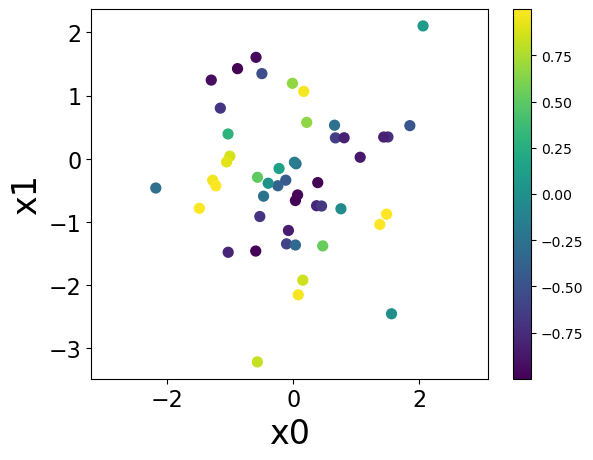

In [2]:
from plotting import plot_data_2d

plot_data_2d(x, y_gt)

## Two-Layer Neural Network

We now create a two-layer neural network and randomly initialize it.

In [3]:
from numpy.random import default_rng

rng = default_rng()

def sigmoid(x):
    from numpy import exp
    return 1 / (1 + exp(-x))

num_neurons = 10

wa = rng.standard_normal(size=(2, num_neurons)) # input weights layer 1
wb = rng.standard_normal(size=(num_neurons, 1)) # input weights layer 2 (output)

y_p = sigmoid(x @ wa) @ wb # note linear output

**Note**

The calculation of `y_p` can be made more explicit (whose intermediate results are needed for the error back propagation):

```python
x_a = x # input layer 1
p_a = x_a @ wa # activation potential layer 1
y_a = sigmoid(p_a) # output layer 1

x_b = y_a # input layer 2 (output neuron)
p_b = x_b @ wb # activation potential layer 2 (output neuron)
y_b = p_b # (linear) output layer 2 (output neuron)

y_p = y_b
```

We now plot its predictions using the function `plot_pred_2d` from `plotting.py`.

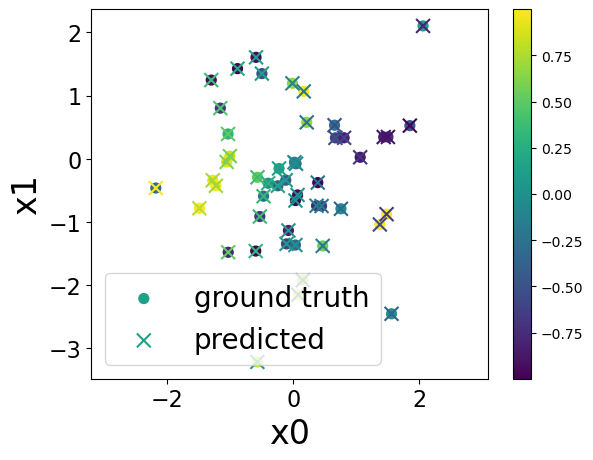

In [4]:
from plotting import plot_pred_2d

plot_pred_2d(x, y_gt, y_p)

## Predition vs Groundtruth Plot

We can now add a second representation of prediction-vs-groundtruth plot, which is provided by function `plot_pred_vs_gt()` now added to `plotting`.

Its code is:

```python
def plot_pred_vs_gt(y_gt, y_p):
    import matplotlib.pyplot as plt

    plt.plot([-1, 1], [-1, 1], "k:")
    plt.scatter(y_gt, y_p, s=10) 
    plt.axis("square")
    plt.xlabel("y groundtruth", fontsize=24)
    plt.ylabel("y predicted", fontsize=24)
    plt.tick_params(axis="both", which="major", labelsize=16)
    plt.show()
```

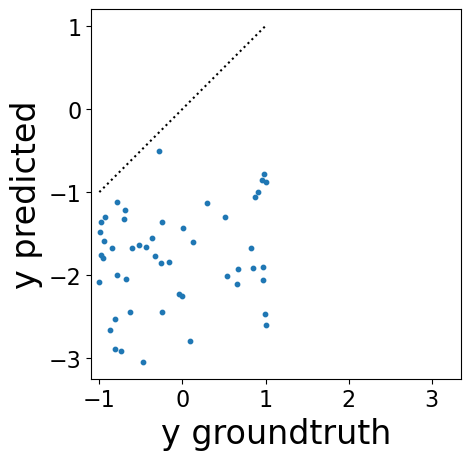

In [5]:
from plotting import plot_pred_vs_gt

plot_pred_vs_gt(y_gt, y_p)

## Training

We now train the neural network...

In [6]:
from numpy import reshape, transpose, sum, zeros, mean
from numpy.random import permutation

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))
	
num_samples = len(x)
num_batches = 10
batch_size = int(num_samples / num_batches)
num_epochs = 10**4
eta = .1 # learning rate

mse_train = zeros((num_epochs,))

for epoch in range(num_epochs):
	permuted_order_samples = permutation(num_samples)
	x_permuted = x[permuted_order_samples]
	y_gt_permuted = y_gt[permuted_order_samples]
	
	for batch_start in range(0, num_samples, batch_size):

		dwa = zeros(wa.shape) # initialize weight increments layer 1
		dwb = zeros(wb.shape) # initialize weight increments layer 2

		for selected in range(batch_start, batch_start + batch_size):
			x_selected = reshape(x_permuted[selected], (1, -1))
			y_gt_selected = reshape(y_gt_permuted[selected], (1, -1))

			x_selected_a = x_selected # input layer 1
			p_a = x_selected_a @ wa # activation potential layer 1
			y_selected_a = sigmoid(p_a) # output layer 1
			
			x_selected_b = y_selected_a # input layer 2 (output neuron)
			p_b = x_selected_b @ wb # activation potential layer 2
			y_selected_b = p_b # output neuron layer 2

			y_p_selected = y_selected_b
			
			error = y_p_selected - y_gt_selected

			delta_b = error * 1
			wb -= eta * delta_b * transpose(x_selected_b) # update weights layer 2

			delta_a = sum(wb * delta_b, axis=1) * d_sigmoid(p_a)
			wa -= eta * delta_a * transpose(x_selected_a) # update weights layer 1

		wa += dwa / batch_size # update weights layer 1
		wb += dwb / batch_size # update weights layer 2

	y_p = sigmoid(x @ wa) @ wb
	mse_train[epoch] = mean((y_p - y_gt)**2)

	print(f"epoch={epoch} MSE = {mse_train[epoch]:.4f}")

epoch=0 MSE = 0.5787
epoch=1 MSE = 0.7043
epoch=2 MSE = 0.5081
epoch=3 MSE = 0.5127
epoch=4 MSE = 0.4816
epoch=5 MSE = 0.4622
epoch=6 MSE = 0.5760
epoch=7 MSE = 0.4581
epoch=8 MSE = 0.4825
epoch=9 MSE = 0.4570
epoch=10 MSE = 0.4459
epoch=11 MSE = 0.5979
epoch=12 MSE = 0.5273
epoch=13 MSE = 0.4343
epoch=14 MSE = 0.4369
epoch=15 MSE = 0.7713
epoch=16 MSE = 0.5348
epoch=17 MSE = 0.3932
epoch=18 MSE = 0.3828
epoch=19 MSE = 0.4466
epoch=20 MSE = 0.3770
epoch=21 MSE = 0.3469
epoch=22 MSE = 0.3188
epoch=23 MSE = 0.4797
epoch=24 MSE = 0.3501
epoch=25 MSE = 0.3082
epoch=26 MSE = 0.2734
epoch=27 MSE = 0.2981
epoch=28 MSE = 0.2507
epoch=29 MSE = 0.2972
epoch=30 MSE = 0.2804
epoch=31 MSE = 0.4069
epoch=32 MSE = 0.1993
epoch=33 MSE = 0.2132
epoch=34 MSE = 0.1899
epoch=35 MSE = 0.1997
epoch=36 MSE = 0.1721
epoch=37 MSE = 0.1945
epoch=38 MSE = 0.1795
epoch=39 MSE = 0.1712
epoch=40 MSE = 0.1374
epoch=41 MSE = 0.1361
epoch=42 MSE = 0.1217
epoch=43 MSE = 0.1459
epoch=44 MSE = 0.1134
epoch=45 MSE = 0.292

... and plot its performance, again using the function `plot_pred_2d` from `plotting.py`...

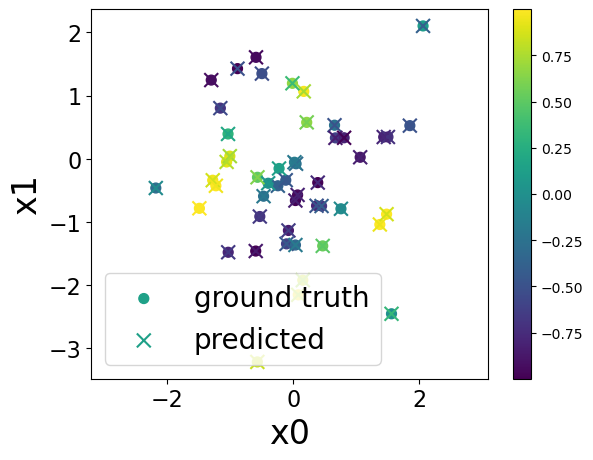

In [7]:
y_p_trained = sigmoid(x @ wa) @ wb

plot_pred_2d(x, y_gt, y_p_trained)

... function `plot_pred_vs_gt()` now added to `plotting`.

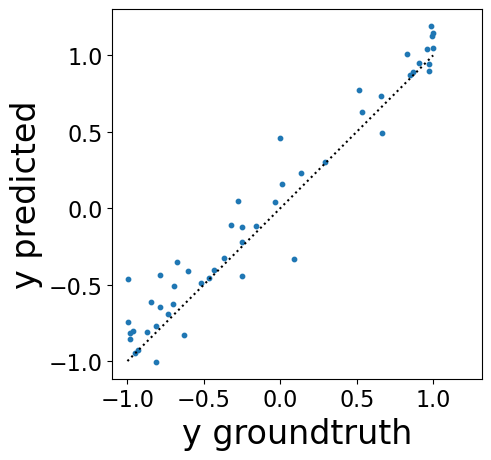

In [8]:
plot_pred_vs_gt(y_gt, y_p_trained)

We can also plot the _mean squared error_ as a function of the training epoch using function `plot_mse()` now added to `plotting`.

Its code is:
```python
def plot_mse(mse, smooth=11, color="tab:orange"):
    import matplotlib.pyplot as plt
    from numpy import convolve, full

    mse_smooth = convolve(mse, full((smooth,), 1 / smooth), mode="valid")

    fig, ax = plt.subplots(1, 2)
    
    fig.set_size_inches(10, 5)
    
    ax[0].plot(mse, c=color)
    ax[0].plot(range(smooth // 2, len(mse) - smooth // 2), mse_smooth, c="k")
    ax[0].set_xlabel("epoch", fontsize=24)
    ax[0].set_ylabel("MSE", fontsize=24)
    ax[0].tick_params(axis="both", which="major", labelsize=16)

    ax[1].loglog(mse, c=color)
    ax[1].loglog(range(smooth // 2, len(mse) - smooth // 2), mse_smooth, c="k")
    ax[1].set_xlabel("epoch", fontsize=24)
    ax[1].set_ylabel("MSE", fontsize=24)
    ax[1].tick_params(axis="both", which="major", labelsize=16)
    
    plt.tight_layout()
    plt.show()
``````

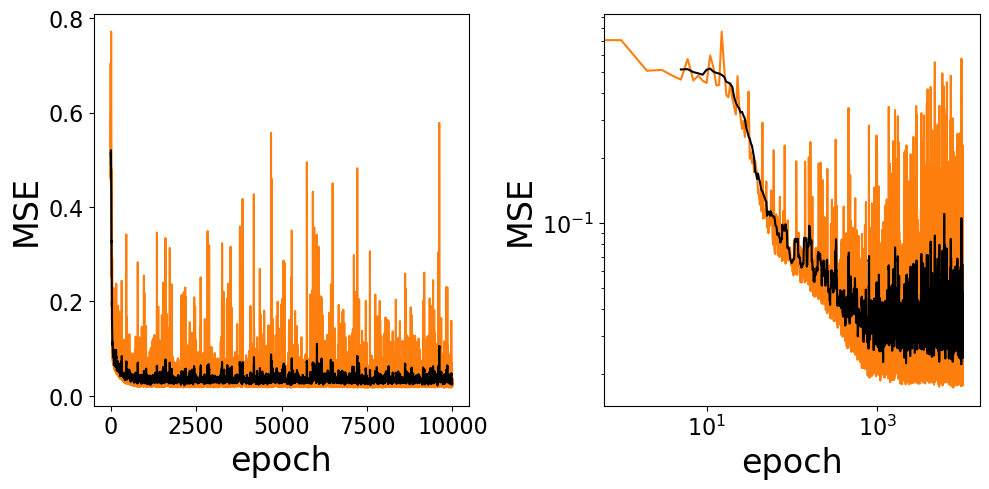

In [9]:
from plotting import plot_mse

plot_mse(mse_train)

## Testing

We now check how the trained neuron works on the test data.

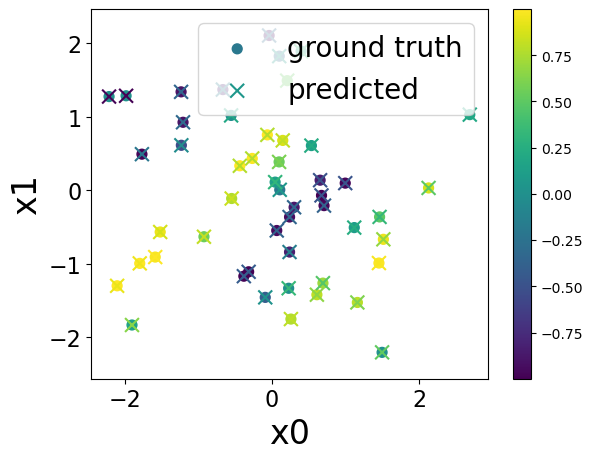

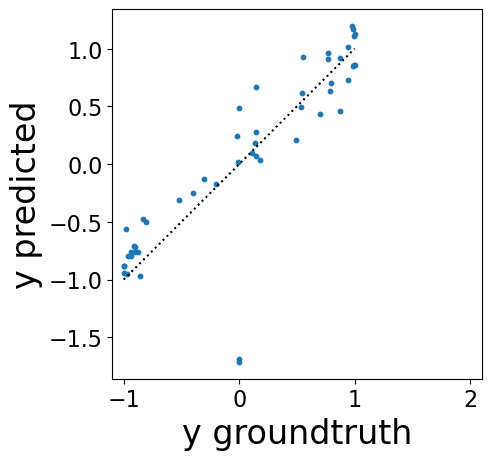

In [10]:
(x_test, y_gt_test) = load_data(filename="data_reg_2d_nonlinear_test.csv")

y_p_trained_test = sigmoid(x_test @ wa) @ wb

plot_pred_2d(x_test, y_gt_test, y_p_trained_test)
plot_pred_vs_gt(y_gt_test, y_p_trained_test)